In [4]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Evaluation metrics for regression problems

Evaluation metrics are useful for explaining the accuracy of our models, comparing different models, and deciding which variables to include into a model.

Let's create some example numeric predictions, and calculate three common evaluation metrics for regression problems:

In [5]:
# define true and predicted response values
y_true = [100, 50, 30, 20]
y_pred = [90, 50, 50, 30]

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

In [6]:
print(mean_absolute_error(y_true, y_pred))

10.0


**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

In [7]:
print(mean_squared_error(y_true, y_pred))

150.0


**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [8]:
print(np.sqrt(mean_squared_error(y_true, y_pred)))
print(mean_squared_error(y_true, y_pred) ** 0.5)

12.24744871391589
12.24744871391589


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them.

Here's an additional example, to demonstrate how MSE/RMSE punish larger errors:

In [9]:
# same true values as above
y_true = [100, 50, 30, 20]

# new set of predicted values
y_pred = [60, 50, 30, 20]

# MAE is the same as before
print(mean_absolute_error(y_true, y_pred))

# RMSE is larger than before
print(np.sqrt(mean_squared_error(y_true, y_pred)))

10.0
20.0


### Computing evaluation metrics for our linear model on the advertising dataset

Let's compute these evaluation metrics for the linear model we have developed for our advertising dataset

In [10]:
# read data into a DataFrame
advert = pd.read_csv('data/advertising/Advertising.csv')
advert.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [11]:
factors = ["TV", "Radio", "Newspaper"]
X = advert[factors]
y = advert["Sales"]

In [12]:
lm = LinearRegression().fit(X, y)
sales_preds = lm.predict(X)

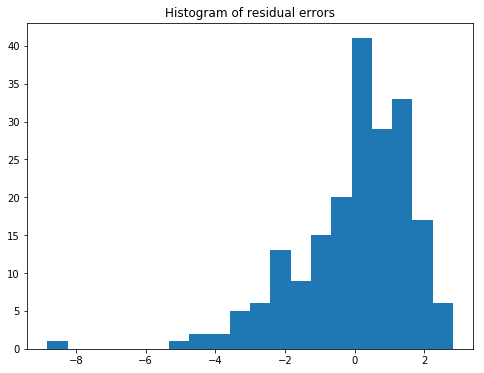

In [13]:
plt.figure(figsize=(8,6))
plt.hist(y - sales_preds, bins=20)
plt.title("Histogram of residual errors")
plt.show()

Plotting the residual errors provides us a useful indication of how our model is performing. Ideally, we would like the errors to be normally distributed around zero with minimal variance.

In [14]:
print("R squared: {}".format(r2_score(y, sales_preds)))
print("MAE: {}".format(mean_absolute_error(y, sales_preds)))
print("MSE: {}".format(mean_squared_error(y, sales_preds)))
print("RMSE: {}".format(np.sqrt(mean_squared_error(y, sales_preds))))

R squared: 0.8972106381789522
MAE: 1.252011229687068
MSE: 2.784126314510936
RMSE: 1.6685701407225697


Our model looks pretty good, with a fairly low RMSE. Remember that the model is fitted to minimize squared errors, but we don't know how it will perform on unseen or new data.

### Model Evaluation

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [15]:
train, test = model_selection.train_test_split(advert, test_size=0.3, random_state=8)
train.shape, test.shape

((140, 4), (60, 4))

In [16]:
X_train = train[factors]
y_train = train["Sales"]
X_test = test[factors]
y_test = test["Sales"]

In [17]:
lm = LinearRegression().fit(X_train, y_train)

In [19]:
print("Training MSE: {}".format(mean_squared_error(lm.predict(X_train), y_train)))
print("Testing MSE: {}".format(mean_squared_error(lm.predict(X_test), y_test)))

Training MSE: 2.6135320944572866
Testing MSE: 3.2452829446902554


### Cross Validation 

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

### Cross Validation on the advertising dataset

In [20]:
kf = model_selection.KFold(n_splits=5, shuffle=True)

In [22]:
rmse_list = []
n = 0
for train_index, test_index in kf.split(advert):
    n += 1
    train = advert.iloc[train_index]
    test = advert.iloc[test_index]
    lm = LinearRegression().fit(train[factors], train["Sales"])
    ypreds = lm.predict(test[factors])
    rmse = np.sqrt(mean_squared_error(ypreds, test["Sales"]))
    rmse_list.append(rmse)
    print("Model {} RMSE: {}".format(n, rmse))
print("Average RMSE: {}".format(np.mean(rmse_list)))

Model 1 RMSE: 1.4227948979972582
Model 2 RMSE: 1.4102265207578601
Model 3 RMSE: 1.6867228503973282
Model 4 RMSE: 2.140240925684851
Model 5 RMSE: 1.735953761535783
Average RMSE: 1.6791877912746158


### Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

### Cross-validation recommendations

- K can be any number, but **K = 5 or 10** is generally recommended
- For classification problems, **stratified sampling** is recommended for creating the folds i.e. Each response class should be represented with equal proportions in each of the K folds